# Greykite time series models

Time series models using Greykite

In [1]:
# Imports
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import plotly.io as pio
pio.renderers.default = "svg"
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.utils.result_summary import summarize_grid_search_results
from collections import defaultdict

In [2]:
most_restricted = pd.read_csv(f'../data/most_restricted.csv')

In [3]:
most_restricted.head()

,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
0,2017-12-31,53.0,65.8,26.4,32.2,23.8,0.0,0.0,0.0,0.0,0.0
1,2018-01-07,58.0,66.0,26.0,40.4,33.8,0.0,0.0,0.0,0.0,0.0
2,2018-01-14,54.2,60.6,22.8,41.0,35.2,0.0,0.0,0.0,0.0,0.0
3,2018-01-21,63.4,65.2,21.6,38.0,33.2,0.0,0.0,0.0,0.0,0.0
4,2018-01-28,66.8,63.2,23.6,36.4,30.4,0.0,0.0,0.0,0.0,0.0


In [4]:
ts = UnivariateTimeSeries()
ts.load_data(
     df=most_restricted[['week', 'depression']],
     time_col="week",
     value_col="depression",
     freq="W-SUN")
print(ts.df.head())

                   ts     y
2017-12-31 2017-12-31  53.0
2018-01-07 2018-01-07  58.0
2018-01-14 2018-01-14  54.2
2018-01-21 2018-01-21  63.4
2018-01-28 2018-01-28  66.8


In [5]:
print(ts.describe_time_col())
print(ts.describe_value_col())

{'data_points': 262, 'mean_increment_secs': 604800.0, 'min_timestamp': Timestamp('2017-12-31 00:00:00'), 'max_timestamp': Timestamp('2023-01-01 00:00:00')}
count    262.000000
mean      56.357252
std        9.168144
min       32.000000
25%       49.250000
50%       55.600000
75%       63.550000
max       77.000000
Name: y, dtype: float64


In [ ]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="month",
     show_mean=True,
     show_quantiles=False,
     show_overlays=True,
     center_values=True,
     overlay_label_time_feature="year",  # splits overlays by year
     overlay_style={"line": {"width": 1}, "opacity": 0.5},
     xlabel="Month",
     ylabel=ts.original_value_col,
     title="Monthly seasonality by year (centered)"
 )
fig.show()

In [ ]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="woy",
     show_mean=True,
     show_quantiles=False,
     show_overlays=True,
     center_values=True,
     overlay_label_time_feature="year",  # splits overlays by year
     overlay_style={"line": {"width": 1}, "opacity": 0.5},
     xlabel="Week of year",
     ylabel=ts.original_value_col,
     title="Weekly seasonality by year (centered)",
 )
plotly.io.show(fig)

In [13]:
# specify dataset information
forecast_horizon = 4  # Forecast 4 weeks
time_col = 'ts'  # "ts"
value_col = 'y'  # "y"
metadata = MetadataParam(
     time_col=time_col,  # name of the time column ("date" in example above)
     value_col=value_col,  # name of the value column ("sessions" in example above)
     freq="W-SUN"  # "H" for hourly, "D" for daily, "W" for weekly, etc.
               # Any format accepted by `pandas.date_range`
 )

In [14]:
cv_min_train_periods = 52 * 2
 # Let CV use most recent splits for cross-validation.
cv_use_most_recent_splits = True
 # Determine the maximum number of validations.
cv_max_splits = 6
evaluation_period = EvaluationPeriodParam(
     test_horizon=forecast_horizon,
     cv_horizon=forecast_horizon,
     periods_between_train_test=0,
     cv_min_train_periods=cv_min_train_periods,
     cv_expanding_window=True,
     cv_use_most_recent_splits=cv_use_most_recent_splits,
     cv_periods_between_splits=None,
     cv_periods_between_train_test=0,
     cv_max_splits=cv_max_splits,
 )

In [15]:
def get_model_results_summary(result):
     """Generates model results summary.

     Parameters
     ----------
     result : `ForecastResult`
         See :class:`~greykite.framework.pipeline.pipeline.ForecastResult` for documentation.

     Returns
     -------
     Prints out model coefficients, cross-validation results, overall train/test evalautions.
     """
     # Get the useful fields from the forecast result
     model = result.model[-1]
     backtest = result.backtest
     grid_search = result.grid_search

     # Check model coefficients / variables
     # Get model summary with p-values
     print(model.summary())

     # Get cross-validation results
     cv_results = summarize_grid_search_results(
         grid_search=grid_search,
         decimals=2,
         cv_report_metrics=None,
         column_order=[
             "rank", "mean_test", "split_test", "mean_train", "split_train",
             "mean_fit_time", "mean_score_time", "params"])
     # Transposes to save space in the printed output
     print("================================= CV Results ==================================")
     print(cv_results.transpose())

     # Check historical evaluation metrics (on the historical training/test set).
     backtest_eval = defaultdict(list)
     for metric, value in backtest.train_evaluation.items():
         backtest_eval[metric].append(value)
         backtest_eval[metric].append(backtest.test_evaluation[metric])
     metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
     print("=========================== Train/Test Evaluation =============================")
     print(metrics)

In [16]:
autoregression = None
extra_pred_cols = ["ct1", "ct_sqrt", "ct1:C(month, levels=list(range(1, 13)))"]

 # Specify the model parameters
model_components = ModelComponentsParam(
     autoregression=autoregression,
     seasonality={
         "yearly_seasonality": 25,
         "quarterly_seasonality": 0,
         "monthly_seasonality": 0,
         "weekly_seasonality": 0,
         "daily_seasonality": 0
     },
     changepoints={
         'changepoints_dict': {
             "method": "auto",
             "resample_freq": "7D",
             "regularization_strength": 0.5,
             "potential_changepoint_distance": "14D",
             "no_changepoint_distance_from_end": "60D",
             "yearly_seasonality_order": 25,
             "yearly_seasonality_change_freq": None,
         },
         "seasonality_changepoints_dict": None
     },
     events={
         "holiday_lookup_countries": []
     },
     growth={
         "growth_term": None
     },
     custom={
         'feature_sets_enabled': False,
         'fit_algorithm_dict': dict(fit_algorithm='ridge'),
         'extra_pred_cols': extra_pred_cols,
     }
 )

forecast_config = ForecastConfig(
     metadata_param=metadata,
     forecast_horizon=forecast_horizon,
     coverage=0.95,
     evaluation_period_param=evaluation_period,
     model_components_param=model_components
 )

 # Run the forecast model
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=ts.df,
     config=forecast_config
 )

Fitting 6 folds for each of 1 candidates, totalling 6 fits


In [17]:
get_model_results_summary(result)

================================ Model Summary =================================

Number of observations: 262,   Number of features: 80
Method: Ridge regression
Number of nonzero features: 80
Regularization parameter: 0.1374

Residuals:
         Min           1Q       Median           3Q          Max
      -13.96       -2.766      -0.2308        2.762        12.51

           Pred_col Estimate Std. Err Pr(>)_boot sig. code             95%CI
          Intercept    55.39    3.382     <2e-16       ***    (49.61, 62.31)
                ct1    1.886     1.18      0.118            (-0.8842, 3.926)
ct1:C(mo... 13)))_2   -3.583    2.807      0.196             (-8.919, 1.882)
ct1:C(mo... 13)))_3    2.244    3.582      0.528             (-4.945, 9.591)
ct1:C(mo... 13)))_4    7.646    4.326      0.078         .   (-1.097, 15.64)
ct1:C(mo... 13)))_5    1.106    3.212      0.724             (-5.086, 8.179)
ct1:C(mo... 13)))_6   0.6291    4.043      0.820             (-7.957, 9.301)
ct1:C(mo... 13))

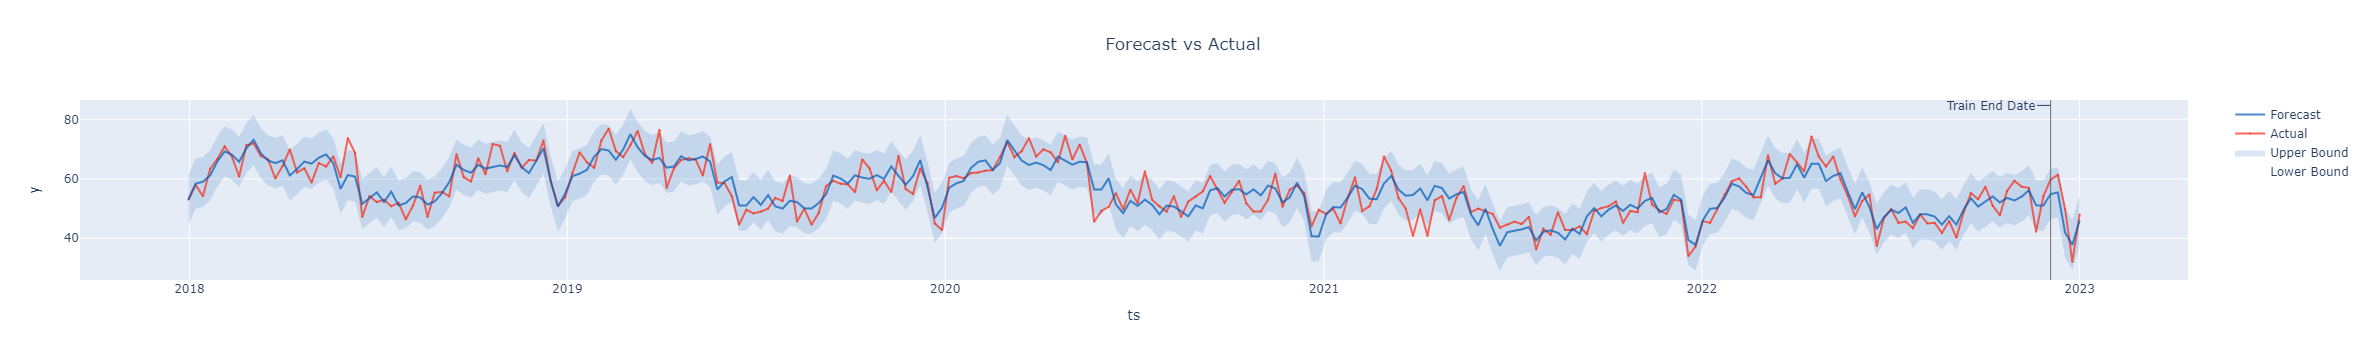

In [18]:
fig = result.backtest.plot()
plotly.io.show(fig)

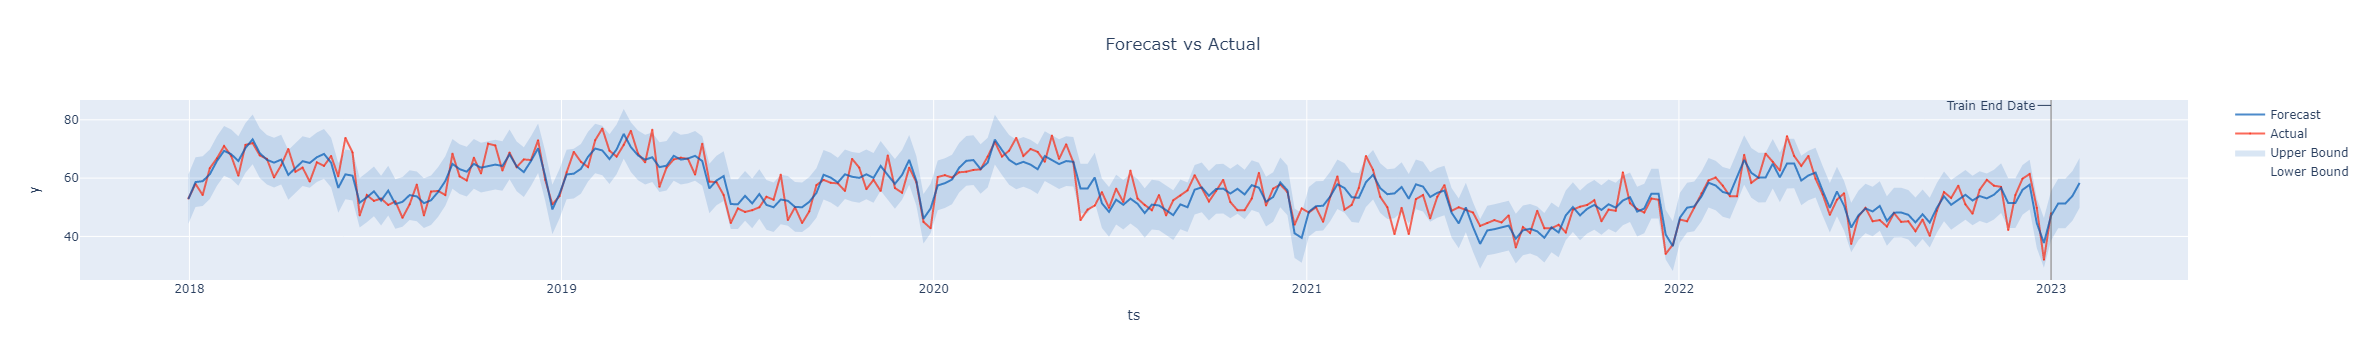

In [19]:
fig = result.forecast.plot()
plotly.io.show(fig)

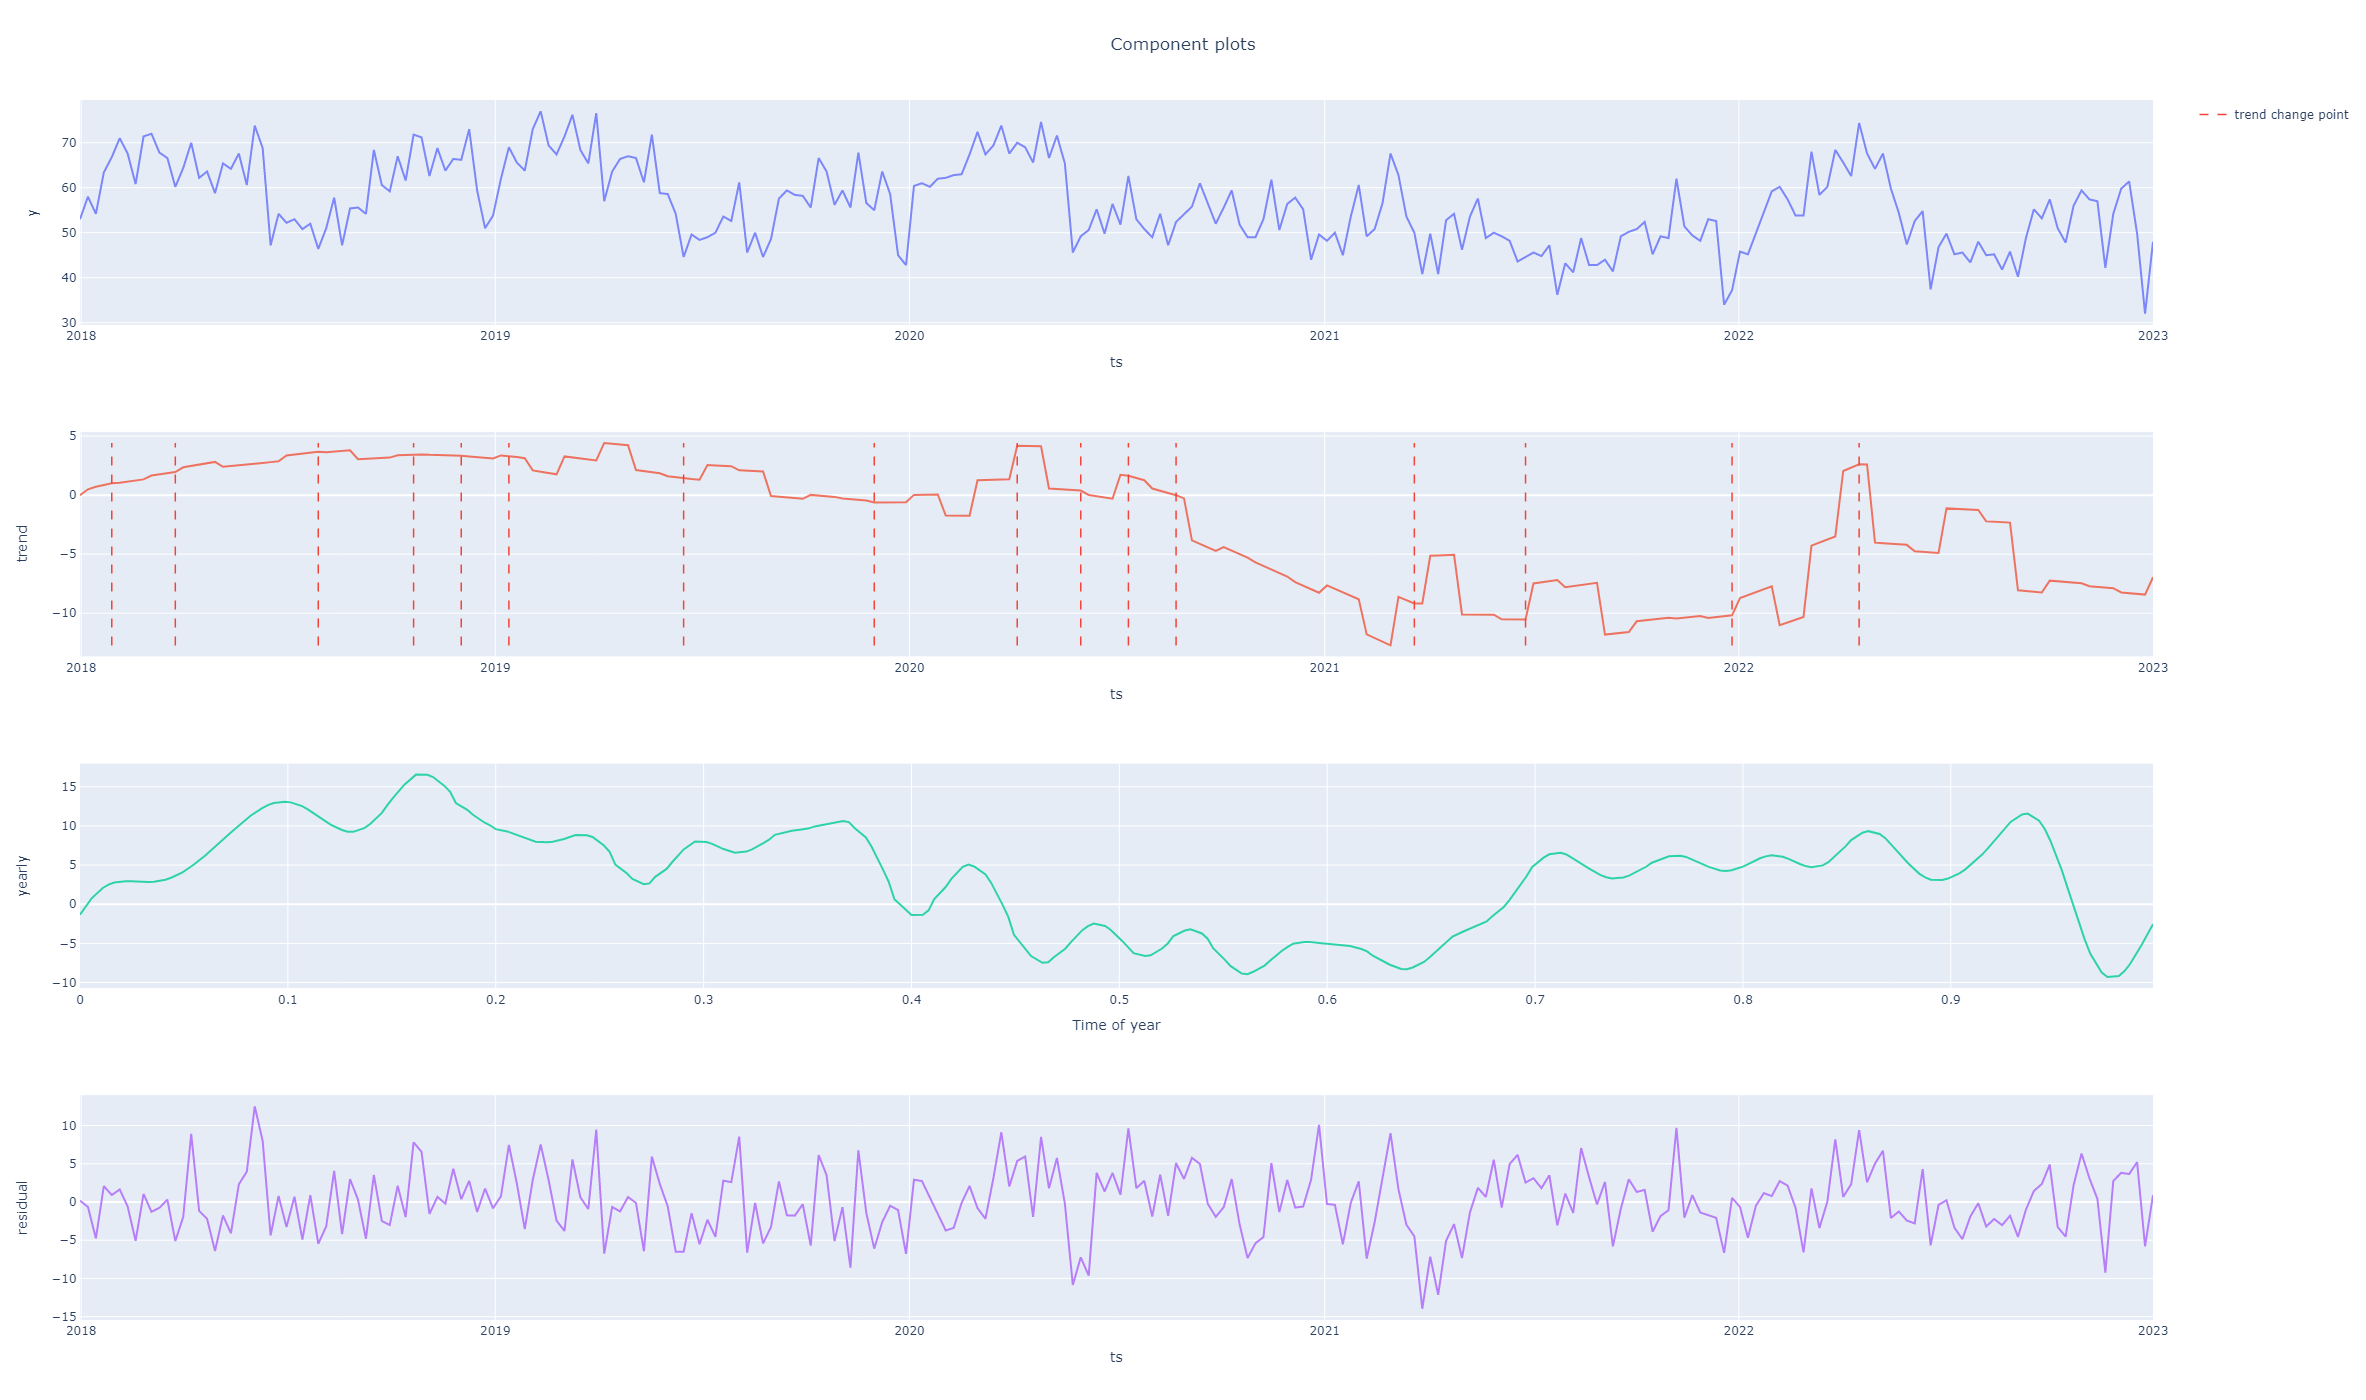

In [20]:
fig = result.forecast.plot_components()
plotly.io.show(fig)

In [21]:
autoregression = {
     "autoreg_dict": {
         "lag_dict": {"orders": [1]},  # Only use lag-1
         "agg_lag_dict": None
     }
 }
extra_pred_cols = ["ct1", "ct_sqrt", "ct1:C(month, levels=list(range(1, 13)))"]

 # Specify the model parameters
model_components = ModelComponentsParam(
     autoregression=autoregression,
     seasonality={
         "yearly_seasonality": 25,
         "quarterly_seasonality": 0,
         "monthly_seasonality": 0,
         "weekly_seasonality": 0,
         "daily_seasonality": 0
     },
     changepoints={
         'changepoints_dict': {
             "method": "auto",
             "resample_freq": "7D",
             "regularization_strength": 0.5,
             "potential_changepoint_distance": "14D",
             "no_changepoint_distance_from_end": "60D",
             "yearly_seasonality_order": 25,
             "yearly_seasonality_change_freq": None,
         },
         "seasonality_changepoints_dict": None
     },
     events={
         "holiday_lookup_countries": []
     },
     growth={
         "growth_term": None
     },
     custom={
         'feature_sets_enabled': False,
         'fit_algorithm_dict': dict(fit_algorithm='ridge'),
         'extra_pred_cols': extra_pred_cols,
     }
 )

forecast_config = ForecastConfig(
     metadata_param=metadata,
     forecast_horizon=forecast_horizon,
     coverage=0.95,
     evaluation_period_param=evaluation_period,
     model_components_param=model_components
 )

 # Run the forecast model
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=ts.df,
     config=forecast_config
 )

Fitting 6 folds for each of 1 candidates, totalling 6 fits


In [22]:
get_model_results_summary(result)

================================ Model Summary =================================

Number of observations: 262,   Number of features: 81
Method: Ridge regression
Number of nonzero features: 81
Regularization parameter: 0.3039

Residuals:
         Min           1Q       Median           3Q          Max
      -13.53       -2.793     -0.06627         2.68         11.5

           Pred_col Estimate Std. Err Pr(>)_boot sig. code             95%CI
          Intercept    47.68    3.904     <2e-16       ***    (39.93, 55.86)
                ct1   0.7962   0.8143      0.334            (-0.9659, 2.226)
ct1:C(mo... 13)))_2   -2.976    2.579      0.248             (-7.626, 2.278)
ct1:C(mo... 13)))_3    1.948    3.185      0.524             (-4.375, 7.943)
ct1:C(mo... 13)))_4     6.08      3.5      0.080         .  (-0.9459, 12.44)
ct1:C(mo... 13)))_5 -0.01677    2.648      0.990             (-5.125, 5.077)
ct1:C(mo... 13)))_6   0.2732    3.383      0.926             (-5.711, 7.796)
ct1:C(mo... 13))

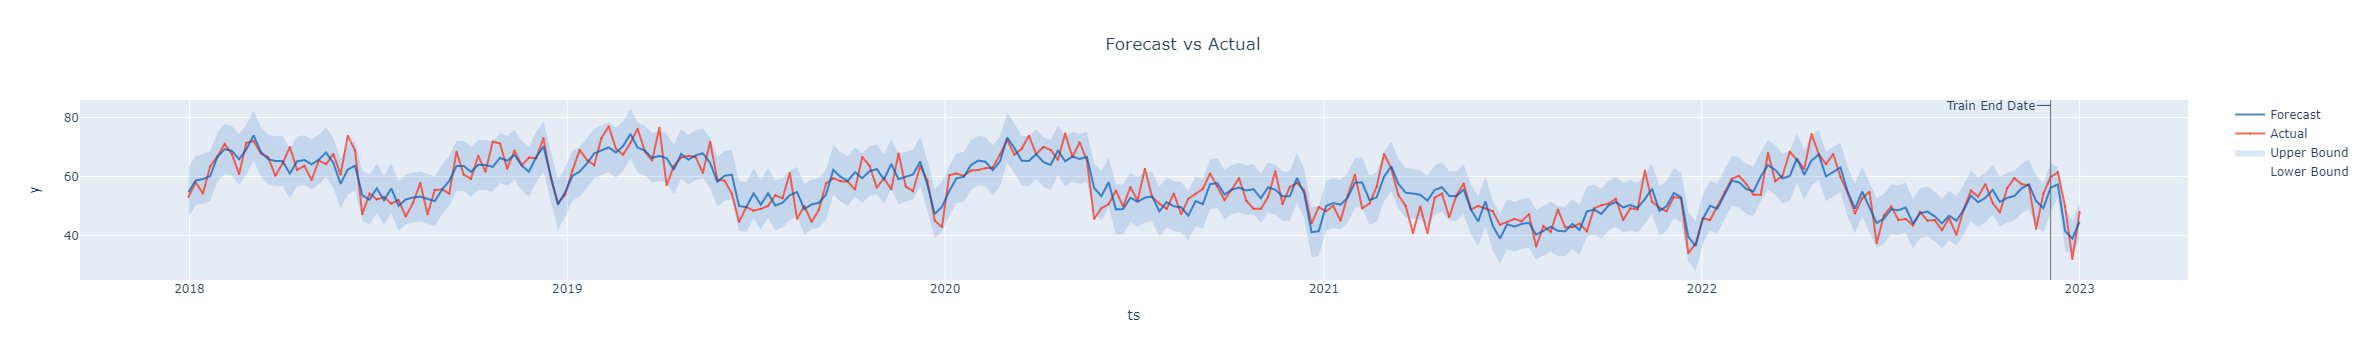

In [23]:
fig = result.backtest.plot()
plotly.io.show(fig)